<img src='../00_common/figures/iaeaheader.svg' style='width:100%'/>
<p style="font-size:2em;padding-bottom: 0.5em; font-weight: bold;">
<em>E-learning course on <br / ><br / >
Advanced Neutron Imaging</em>
</p> 

# Noise in neutron images
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## What you will learn in this tutorial
Noise is unavoidable in any measurement. It is, in particular, very much present in neutron images due to the low neutron count. In this tutorial, you will learn about the following topics:
- What is noise?
- Noise types
- Noise and signal to noise ratio
- The impact of exposure time and pixel size on the SNR

### Needed mathematical concepts
- Average and variance 
- Histogram
- Distribution functions

#### Using the notebook
The cells in the notebook contain either executable python code or text. The cells are inteded to be executed in the order they appear and you can execute the code in a cell by pressing ctrl+enter or by clicking on the _Run_ button above. 

All code can be modified if you want to experiment with the code. Experimenting is even encouraged. It is always possible to get the original notebook from the repository if you would change the code too much.

The cells have been prepared in a manner that first demonstrates a concept and in some cases the needed plotting to show the result. The visualization is mostly not needed to understand at first, but it can give you some inspiration for your own future data visualization.


#### Before we start, we need to load some modules.
Python is a language that becomes powerful with the large number of modules that can be added. Each module has a specific purpose. The most important modules in this tutorial are ```numpy``` for mathmatical functions and numeric arrays and ```matplotlib``` for plotting data and showing images. A new module package in this tutorial is SciKit Image or ```skimage``` that provides image processing functions.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from skimage.io import imread
from scipy.ndimage import convolve
from skimage.morphology import disk
from skimage.transform import resize
from itertools import product

import os
from io import StringIO
import skimage as ski

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline 

# The following code is a technical segment for better Colab integration.
import sys
if "google.colab" in sys.modules:
    # Running on colab we need to download repos from github
    !rm -rf scripts
    !rm -rf ImageProcessing
    !git clone https://github.com/ImagingELearning/ImageProcessing.git
    !git clone https://github.com/neutronimaging/scripts.git
    data_path="/content/ImageProcessing/tutorials/00_common/data/"
    sys.path.append("/content/scripts/python/")
    sys.path.append("/content/ImageProcessing/tutorials/00_common/")
else: 
    # Running locally on your computer
    data_path = "../00_common/data/"
    sys.path.append('../00_common/')

import readers as rd

# Noise in images

Noise is in very general terms for the unwanted information in a signal. 

More specifically, we are talking about random contributions that obscure the image information we are interested in.

Noise present to some degree in any measurement. In neutron imaging it is also very much present. The noise strength varies depending on the acquisiton conditions of your experiment. Important factor to consider are

- Neutron flux
- Exposure time 
- Pixel size
- Scintillator type and its detection efficiency.

The first is difficult to change but the other three can be changed to improve the signal to noise ratio. In many experiments, you still have to trade the required instrument settings against lower signal to noise ratio.

This is mainly a theory notebook, but there are some cells you can modify and learn more about how the noise changes under different conditions.

## Noise types
Noise can have many different characteristics. In general, it is driven by a random distribution.

- Spatially uncorrelated noise  
With spatially uncorrelated noise each pixel has a random value which is independend of the pixel neighborhood. This is also the easiest noise type to simulate.

- Event noise  
The event noise has a random activation function that triggers the event of each pixel with some probabilty. This noise type produces spots randomly distributed over the image. The spots may also have random intensity.

- Structured noise  
The structured noise depends on the values of the pixel neighborhood and is thus spatially correlated. It is mostly driven by an uncorrelated noise source which is blurred by a weighted combination of the neighborhood.

The figure below shows examples of the three noise types.

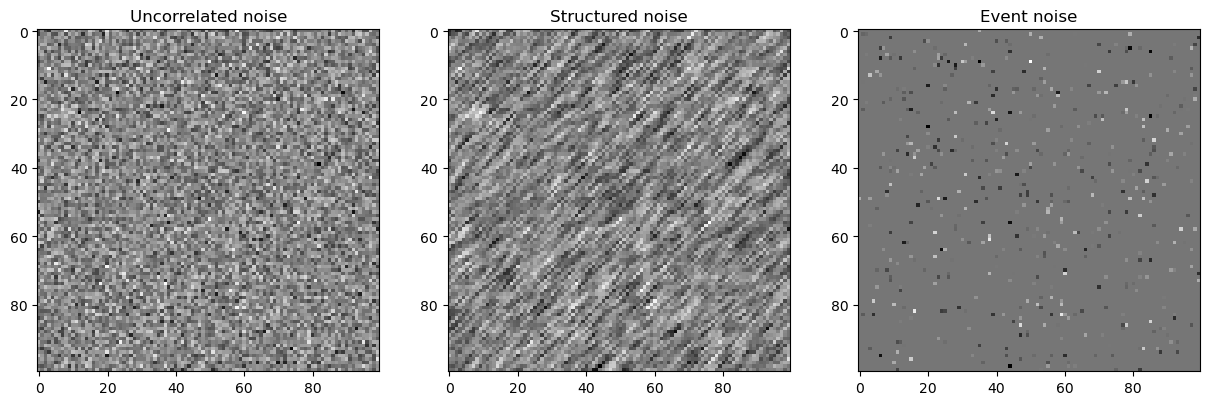

In [43]:
# Make some noise
noise_gaussian   = np.random.normal(0,1,size=[100,100])
noise_structured = convolve(noise_gaussian,[[0,0,0,0,1],[0,0,0.2,2,0.2],[0,0.5,5,0.5,0],[0.2,2,0.2,0,0],[1,0,0,0,0]])
noise_event      = (0.95<np.random.uniform(size=[100,100]))*noise_gaussian

# Show the results
fig,ax=plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(noise_gaussian,cmap='gray',interpolation='none')
ax[0].set_title('Uncorrelated noise')
ax[1].imshow(noise_structured,interpolation='none',cmap='gray')
ax[1].set_title('Structured noise')
ax[2].imshow(noise_event,interpolation='none',cmap='gray')
ax[2].set_title('Event noise');

The type of noise gives you an indication how to process the images and you can also get an idea of what problems you can expect in your analysis. Mostly, you will see a combination of all three types to various degrees.

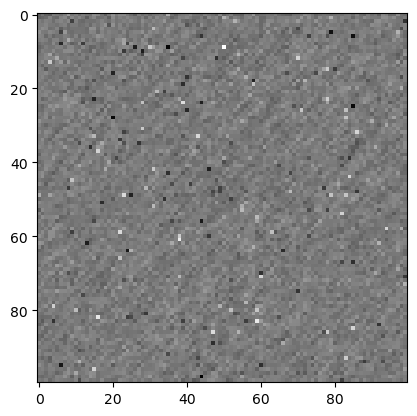

In [44]:
plt.imshow(noise_gaussian+0.1*noise_structured+5*noise_event,interpolation='none',cmap='gray');

This is often the case in neutron imaging where the uncorrelated noise is driven by the counting noise of the neutrons. The neutron noise is however also blurred by the scintilator which makes it rather appear as splats with some pixels radius. Then there may be structures introduced by the scintillator texture and finally there will be randomly distributed outliers with limited extent, the spots. The spots are generally brighter than the main image content, but there can also be dark spots from detector faults or from the normalization process. 

### Gaussian noise
Gaussian noise is the most common random distribution. All other distributions asymptotically converges towards the Gaussian distribution thanks to the central limit theorem. The Gaussian noise is an easy distribution to work with when you derive signal processing models. This is also the reason why it is so popular to use this model as an approximation also for non-Gaussian noise.

Gaussian noise has the following properties:
* Additive
* Easy to model 
* Law of large numbers

__Distribution function__

$$n(x)=\frac{1}{\sqrt{2\pi\sigma}}\exp^{-\left(\frac{x-\mu}{2\sigma}\right)^2}$$

Below you see plots of the Gaussian distribution with different values for $\mu$ and $\sigma$.

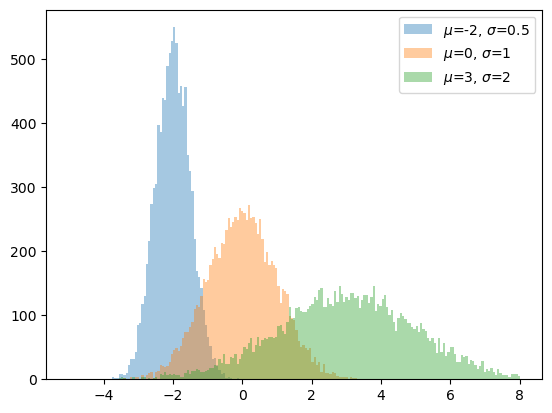

In [45]:
mu    = [-2,0,3]
sigma = [0.5,1,2]

for m,s in zip (mu,sigma) :
    plt.hist(np.random.normal(m,s,size=10000),
             bins=np.linspace(-5,8,200),
             alpha=0.4,
             label='$\mu$={0}, $\sigma$={1}'.format(m,s));

plt.legend();

### Poisson noise
The Poisson noise is the central noise model for event counting processes. It is thus the type of noise you see in imaging as the detectors in some sense is counting the number of particles arriving at the detector, e.g. photons or neutrons. This noise distribution changes shape with increasing number of particles; the distribution is clearly asymmetric for few particles while it takes a Gaussian shape when many particles are counted. It is also multiplicative in contrast to the Gaussian noise. This is in other words the noise distribution you need to use if you want to model image noise correctly.

* Multiplicative
* Physically correct for event counting

__Distribition function__ 

$$p(x)=\frac{\lambda^{k}}{k!} e^{-\lambda\,x}$$

The plot below shows the Poisson distribtions for $\lambda$=3, 6, and 10

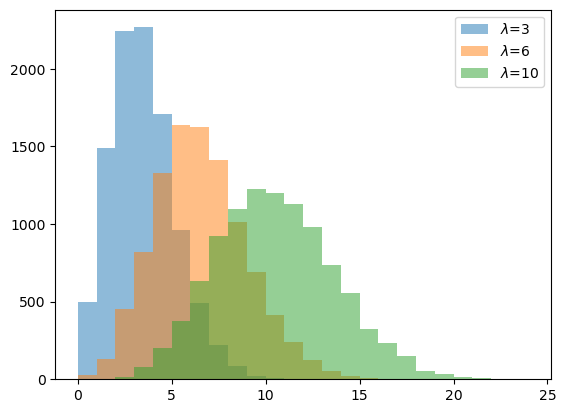

In [46]:
L=[3,6,10]

for l in L: 
    plt.hist(np.random.poisson(l,size=10000),bins=np.arange(0,25),alpha=0.5, label='$\lambda$={}'.format(l));
    
plt.legend();

Here, you can see that the width and position of the poisson noise changes with $\lambda$. 

### Compare Gaussian and Poisson noise on signal
Now, let's compare relaizations of Gaussian and Poisson noise overlaid on a sine curve. The important thing to observe is that the noise amplitude is independent of the signal value and constant for the Gaussian noise. For Poisson noise it is very different. The noise amplitude changes with the signal values. Higher signal strength also produces greater noise amplitudes.

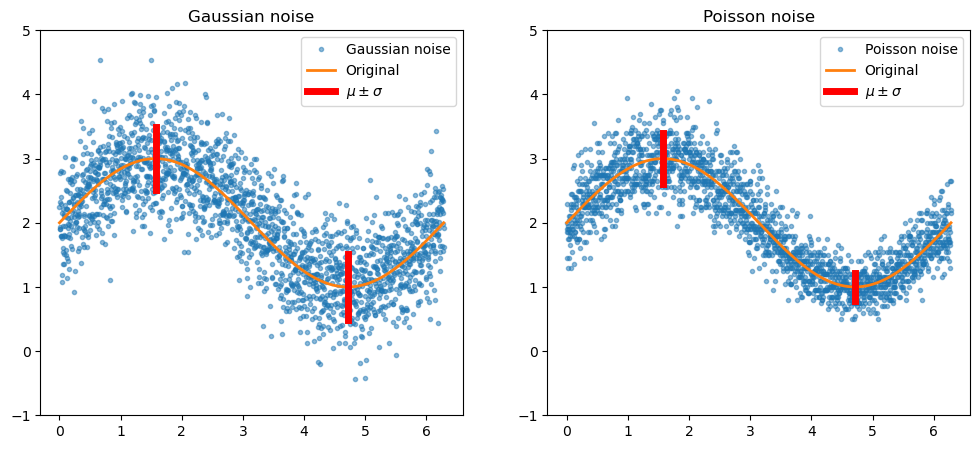

In [47]:
x=np.linspace(0,2*np.pi,2000)
y=1*np.sin(x)+2

idxmax = np.argmax(y)
idxmin = np.argmin(y)

fig,ax=plt.subplots(1,2,figsize=(12,5))
np.random.seed(42)

gn=y+np.random.normal(0,0.5,size=len(x))
ax[0].plot(x,gn,'.',label='Gaussian noise',alpha=0.5)
ax[0].plot(x,y,label='Original',lw=2)
ax[0].set_ylim([-1,5])
ax[0].set_title('Gaussian noise')
stdmin = gn[(idxmin-100):(idxmin+100)].std()
stdmax = gn[(idxmax-100):(idxmax+100)].std()
ax[0].plot([x[idxmin],x[idxmin]],[y[idxmin]+stdmin,y[idxmin]-stdmin],lw=5,c='red',label=r"$\mu \pm \sigma$")
ax[0].plot([x[idxmax],x[idxmax]],[y[idxmax]+stdmax,y[idxmax]-stdmax],lw=5,c='red')
ax[0].legend()

pn=np.random.poisson(y*20)/20
ax[1].plot(x,pn,'.',label='Poisson noise',alpha=0.5)
ax[1].plot(x,y,label='Original',lw=2)
ax[1].set_ylim([-1,5])
ax[1].set_title('Poisson noise');

stdmin = pn[(idxmin-100):(idxmin+100)].std()
stdmax = pn[(idxmax-100):(idxmax+100)].std()
ax[1].plot([x[idxmin],x[idxmin]],[y[idxmin]+stdmin,y[idxmin]-stdmin],lw=5,c='red',label=r"$\mu \pm \sigma$")
ax[1].plot([x[idxmax],x[idxmax]],[y[idxmax]+stdmax,y[idxmax]-stdmax],lw=5,c='red')
ax[1].legend();

In this example, you see that the noise variance is constant for Gaussian noise, while it depends in the signal amplitude for Poisson noise. We will look into this more soon in an example where we simulate a neutron image.

# Signal to noise ratio
It is important to know how strong the noise is compared to the signal in order to decide how to proceed with the analysis. Therefore, we need a metric to quantify the noise. 

The Signal to noise ratio measures the noise strengh in a signal

__Definition__

$$SNR=\frac{mean(f)}{stddev(f)}$$

Sometimes the term contrast to noise ratio is also used. This means that you measure the intensity difference in between two relevant features and divide this by the noise.

## Compute the SNR in an image
To compute the SNR you have to 
1. Select a region of the image with near constant intensity (not considering the noise)
2. Compute average intensity and standard deviation
3. Compute the SNR

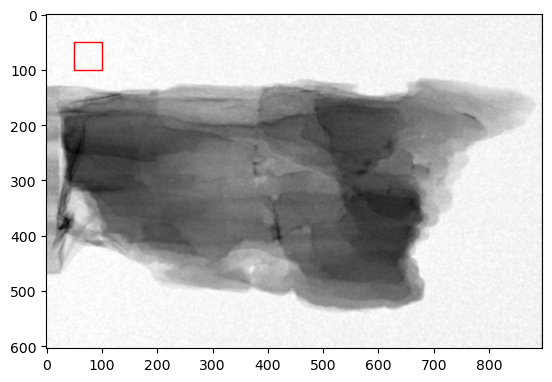

In [54]:
img = np.load(data_path+'wood.npy')
plt.imshow(img, cmap='gray')
# Create a Rectangle patch
rect = patches.Rectangle((50, 50), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect);

In [49]:
avg = np.mean(img[50:100,50:100])
std = np.std(img[50:100,50:100])
SNR = avg/std
print('avg={0:0.4f}, std={1:0.4f} => SNR=avg/std={2:0.2f}'.format(avg,std,SNR))

avg=0.9877, std=0.0093 => SNR=avg/std=106.12


It is important to measure the SNR in a region without any gradients or steep edges. Such features would result in misleading SNR values as both average and standard deviation would reflect the local structures more than the noise.

## Signal to noise ratio for Poisson noise
The SNR of poisson noise is particularly easy to compute because $E[x]=v[x]$. This means that the SNR is proportional to the square root of the number of particles. 

- For a Poisson distribution the SNR is :

$$SNR=\frac{E[x]}{s[x]}\sim\frac{N}{\sqrt{N}}=\sqrt{N}$$

- $N$ is the number of particles $\sim$ exposure time

where _N_ is the number of captured particles. The figure below shows two neutron images acquired at 0.1s and 10s respectively. The plot shows the signal to noise ratio obtained for different exposure times.

The signal to noise ratio can be improved by increasing the number of neutrons per pixel. This can be achived through increasing
- Neutron flux - this is usually relatively hard as the neutron sources operate with the parameters it is designed for. There is a posibilty by changing the neutron aperture, but has an impact of the beam quality.
- Exposure time - the exposure time can be increased but in the end there is a limitation on how much this can be used. Beam time is limited which means the experiment must be finished in a given time. There is also an upper limit on the exposure time defined by the observed sample or process when it changes over time. Too long exposure times will result in motion artefacts.
- Pixel size - increasing the pixel size means that neutrons are collected over a greater area and thus more neutrons are captured during the exposure. The limit on how much you can increase the pixel size is defined by the smallest features you want to detect.
- Detector material and thickness - the number of captured neutrons depends on the scintillator material and how thick it is. The thickness does however have an impact on the resolution. Therefore scintillator thickness and pixel size often increase in parallel as there is no point in oversampling a smooth signal to much.

In the end, there are many parameters that combined results in the SNR you obtain. These parameters are tuned to match the experiment conditions.

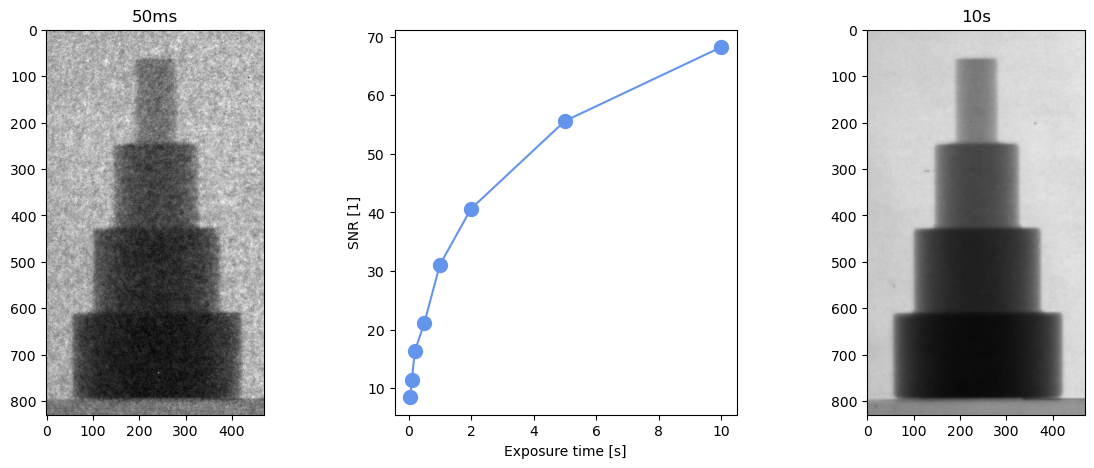

In [53]:
exptime=np.array([50,100,200,500,1000,2000,5000,10000])
snr = np.array([ 8.45949767, 11.40011621, 16.38118766, 21.12056507, 31.09116641,40.65323123, 55.60833117, 68.21108979]);

marker_style = dict(color='cornflowerblue', linestyle='-', marker='o',markersize=10, markerfacecoloralt='gray');

fig,ax = plt.subplots(1,3,figsize=(15,5)) 

ax[1].plot(exptime/1000,snr, **marker_style);
ax[1].set_xlabel('Exposure time [s]');
ax[1].set_ylabel('SNR [1]')

img50ms=plt.imread(data_path+'tower_50ms.png'); 
img10000ms=plt.imread(data_path+'tower_10000ms.png');

ax[0].imshow(img50ms,cmap='gray');    ax[0].set_title('50ms'); 
ax[2].imshow(img10000ms, cmap='gray'); ax[2].set_title('10s');

# Simulate neutron transmission with noise

In this example we simulate the noise in an image base on the number of detected neutrons. This is an incomplete model of the imaging system. It does not include detector efficiency and blurring. Still, it gives you an idea of how the exposure time, pixel size and neutron flux have an impact on the signal to noise ratio.

The ```simulateTransmission``` function creates an image as it would appear with the specified number of neutrons.

In [51]:
def simulateTransmission(neutrons=100,scalex=20,scaley=50) :
    img=np.array([[  1,   1,   1,   1,   1,   1,   1,   1,   1,  1,    1,   1, 1.0],
                  [1.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 1.0],
                  [  1,   1,   1,   1,   1,   1,   1,   1,   1,  1,    1,   1, 1.0]])
    
    img=np.repeat(img,scalex,axis=1)
    img=np.repeat(img,scaley,axis=0)
    img=neutrons*img
    
    img=np.random.poisson(img)
    
    return img

In this example, you can change exposure time, pixel size, and neutron flux. The detection efficiency is not included in thos simplified model. You can use this model to mimic the images of the instrument you are using.

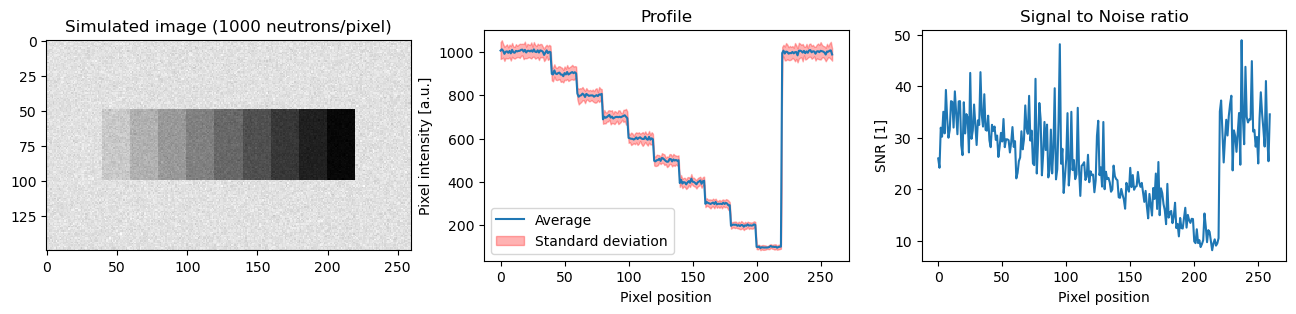

In [52]:
expTime  = 1    # s
pixSize  = 100  # um
flux     = 1e7  # neutrons/cm2/s

neutrons = expTime * (pixSize * 1e-4) ** 2 * flux # calculates how many neutrons there will be per pixel
img = simulateTransmission(neutrons=neutrons) # A 'hidden' function in the notebook

m   = img[55:80].mean(axis=0)
s   = img[55:80].std(axis=0)
SNR = m/s

# Visualization
fig, ax = plt.subplots(1,3,figsize=(16,3))
ax[0].imshow(img, interpolation='None',cmap='gray')
ax[0].set_title('Simulated image ({0:0.0f} neutrons/pixel)'.format(neutrons))
ax[1].plot(m,label='Average')
ax[1].fill_between(x=range(img.shape[1]), y1=m-s,y2=m+s,color='r',alpha=0.3,label='Standard deviation');
ax[1].legend(); ax[1].set_xlabel('Pixel position'); ax[1].set_ylabel('Pixel intensity [a.u.]'); ax[1].set_title('Profile')
ax[2].plot(SNR);
ax[2].set_xlabel('Pixel position'); ax[2].set_ylabel('SNR [1]'); ax[2].set_title('Signal to Noise ratio');

This example shows how different acquisition condition limits our ability to distinguish between different reqions.

## Questions

1. Why is the understanding of noise and its orgin relevant to neutron imaging?
2. Which probability distribution is most relevant in neutron imaging? 
3. Can you improve the signal to noise ratio at experiment time? 
    - What are the easiest methods to change the SNR?
    - What is the hardest way to improve the SNR?
    - Why would you decide to accept a lower SNR?
4. How many more neutrons would you need to double the SNR?

# Outlook
Now we know how to change the signal to noise ratio at experiment time. In an upcoming tutorial, you will learn how image filters can be used to improve the SNR.

## Summary

In this tutorial we have seen that there are different types of noise in neutron images and that the counting noise often is dominant. This type of noise depends on the number of detected neutrons. A demonstration allowed you to experiment with different means to increase the number of neutrons per pixel.